# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

- As bases de dados são os preços dos imóveis do Rio de Janeiro obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [55]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import prediction_error
import shap

In [3]:
meses = {'jan': 1, 'fev':2, 'mar':3, 'abr':4, 'mai':5, 'jun':6, 'jul':7, 'ago':8, 'set':9, 'out':10, 'nov':11, 'dez':12}

caminho_bases = pathlib.Path('dataset')

base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    
    mes = meses[arquivo.name[:3]]
    ano = arquivo.name[-8:]
    ano  = int(ano.replace('.csv', ''))
    
    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = base_airbnb.append(df)
display (base_airbnb)

D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (62,87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


id                            listing_url       scrape_id  \
0         14063     https://www.airbnb.com/rooms/14063  20180414160018   
1         17878     https://www.airbnb.com/rooms/17878  20180414160018   
2         24480     https://www.airbnb.com/rooms/24480  20180414160018   
3         25026     https://www.airbnb.com/rooms/25026  20180414160018   
4         31560     https://www.airbnb.com/rooms/31560  20180414160018   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2018-04-14                          Living in a Postcard   
1       2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2       2018-04-14              Nice and cozy near Ipanema Beach   
3       2018-04-14     Beautiful Modern Decorated Studio in Copa   
4       2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Besides the most iconic's view, our apartment ...   
1      Please note that special rates apply for New Y...   
2      My studio is located in the best  of Ipanema. ...   
3      Our apartment is a little gem, everyone loves ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0                                                    NaN   
1      - large balcony which looks out on pedestrian ...   
2      The studio is located at Vinicius de Moraes St...   
3      This newly renovated studio (last renovations ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Besides the most iconic's view, our apartment ...                none   
1      Please note that special rates apply for New Y...                none   
2      My studio is located in the best  of Ipanema. ...                none   
3      Our apartment is a little gem, everyone loves ...                none   
4      This nice and clean 1 bedroom apartment is loc...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

### Selecionando Colunas relevantes para o preço

In [4]:
#levei para o excel para analisar as colunas qualitativamente
#base_airbnb.head(1000).to_csv('colunastotais.csv', sep = ";")

In [5]:
#após análise, excluí as colunas que acredito não impactar o preço, restando 34 colunas. 
#As colunas excluídas eram, em sua maioria, colunas com todos os valores iguais, 
#ou colunas redundantes com as que mantive no projeto.
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']
base_airbnb = base_airbnb.loc[:, colunas]
display (base_airbnb)

host_response_time host_response_rate host_is_superhost  \
0                     NaN                NaN                 f   
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count   latitude  longitude property_type  \
0                      1.0 -22.946854 -43.182737     Apartment   
1                      2.0 -22.965919 -43.178962   Condominium   
2                      1.0 -22.985698 -43.201935     Apartment   
3                      3.0 -22.977117 -43.190454     Apartment   
4                      1.0 -22.983024 -43.214270     Apartment   
...                    ...        ...        ...           ...   
34324                  0.0 -23.003180 -43.342840     Apartment   
34325                  0.0 -22.966640 -43.393450     Apartment   
34326                 32.0 -22.962080 -43.175520     Apartment   
34327                  0.0 -23.003400 -43.341820     Apartment   
34328                  5.0 -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             4        1.0  ...   
1      Entire home/apt             5        1.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             3        1.0  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                            9.0                    9.0   
1                            9.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                             9.0                    9.0                 9.0   
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  

### Tratar valores nulos

In [6]:
print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [7]:
#como podemos ver, há colunas com mais de 300 mil dados NaN.
#optei por excluir essas colunas para não criar um viés para o modelo (como alterar para 0 por exemplo)
#pois analisando as variáveis, os valores nulos em "cleaning fee" e security deposit apenas não foram preenchidos pois
#a taxa está inclusa apenas nas descrições, além de que por serem maioria, daria muito destaque a quem simplesmente preencheu,
#o que poderia fazer o modelo dar preferência a quem preencheu na hora de precificar.

base_airbnb = base_airbnb.drop(columns=['host_response_time','host_response_rate','security_deposit','cleaning_fee','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value'])


In [8]:
print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [9]:
#além disso, irei excluir as linhas que contém dados nulos, visto que não acredito ser possível trocar por 0
#pois parecem apenas não ter sido preenchidas as informações(como numero de banheiros, impossivel ser 0).
#Preferi não trocar por 0 ou pela média, pois acredito que os valores não preenchidos de "banheiros"
#não ficariam adequados quando substituidos por 0 ou pela média, pois dificilmente um imóvel não teria banheiros, ou quartos,
#Além de tudo, 2.000 linhas num universo de quase 900.000 não será significante para justificar um ajuste ao invés de excluir.

base_airbnb = base_airbnb.dropna(how = 'any', axis=0)
print(base_airbnb.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [10]:
base_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897709 entries, 0 to 34328
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   host_is_superhost         897709 non-null  object 
 1   host_listings_count       897709 non-null  float64
 2   latitude                  897709 non-null  float64
 3   longitude                 897709 non-null  float64
 4   property_type             897709 non-null  object 
 5   room_type                 897709 non-null  object 
 6   accommodates              897709 non-null  int64  
 7   bathrooms                 897709 non-null  float64
 8   bedrooms                  897709 non-null  float64
 9   beds                      897709 non-null  float64
 10  bed_type                  897709 non-null  object 
 11  amenities                 897709 non-null  object 
 12  price                     897709 non-null  object 
 13  guests_included           897709 non-null  in

In [11]:
#precisei mudar o tipo das colunas: price, extra_people para número float
#price está usando $ e separando milhar com ",", portanto:
base_airbnb['price'] = base_airbnb['price'].str.replace("$", "")
base_airbnb['price'] = base_airbnb['price'].str.replace(",", "")
base_airbnb['price'] = base_airbnb['price'].astype(np.float32)
#PS: pesquisando, descobri uma boa prática para grandes bases, em usar o np.float32 pois deixa aquele dado com menos bits.
#porém não irei tratar TODAS as colunas com esses dados, 
#pois não cheguei a olhar a fundo que tipos de dados não podem ser convertidos


<ipython-input-11-dce652aeb2d4>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  base_airbnb['price'] = base_airbnb['price'].str.replace("$", "")


In [12]:
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace("$", "")
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(",", "")
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32)

base_airbnb.info()

<ipython-input-12-e3d03eebd9ea>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace("$", "")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 897709 entries, 0 to 34328
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   host_is_superhost         897709 non-null  object 
 1   host_listings_count       897709 non-null  float64
 2   latitude                  897709 non-null  float64
 3   longitude                 897709 non-null  float64
 4   property_type             897709 non-null  object 
 5   room_type                 897709 non-null  object 
 6   accommodates              897709 non-null  int64  
 7   bathrooms                 897709 non-null  float64
 8   bedrooms                  897709 non-null  float64
 9   beds                      897709 non-null  float64
 10  bed_type                  897709 non-null  object 
 11  amenities                 897709 non-null  object 
 12  price                     897709 non-null  float32
 13  guests_included           897709 non-null  in

### Análise Exploratória e Tratar Outliers

In [13]:
base_airbnb.describe()

host_listings_count       latitude      longitude   accommodates  \
count        897709.000000  897709.000000  897709.000000  897709.000000   
mean              8.540508     -22.965346     -43.253856       4.211794   
std              47.083956       0.034776       0.097373       2.613927   
min               0.000000     -23.073400     -43.738920       1.000000   
25%               1.000000     -22.984690     -43.322560       2.000000   
50%               1.000000     -22.970675     -43.200070       4.000000   
75%               3.000000     -22.946080     -43.186930       6.000000   
max            1495.000000     -22.748953     -43.103709     160.000000   

           bathrooms       bedrooms           beds          price  \
count  897709.000000  897709.000000  897709.000000  897709.000000   
mean        1.695061       1.645698       2.601979     648.062195   
std         1.197992       1.078560       2.069426    1705.104980   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000     151.000000   
50%         1.000000       1.000000       2.000000     297.000000   
75%         2.000000       2.000000       3.000000     601.000000   
max       200.000000      45.000000      86.000000  138288.000000   

       guests_included   extra_people  minimum_nights  maximum_nights  \
count    897709.000000  897709.000000   897709.000000    8.977090e+05   
mean          1.677594      40.156227        4.559410    4.182215e+04   
std           1.529591      98.383331       20.889129    7.321626e+06   
min           1.000000       0.000000        1.000000    1.000000e+00   
25%           1.000000       0.000000        1.000000    3.000000e+01   
50%           1.000000       0.000000        2.000000    1.125000e+03   
75%           2.000000      50.000000        4.000000    1.125000e+03   
max          36.000000    5631.000000     1224.000000    2.147484e+09   

       number_of_reviews            ano            mes  
count      897709.000000  897709.000000  897709.000000  
mean            7.730099    2018.862824       6.326888  
std            21.819157       0.716148       3.398323  
min             0.000000    2018.000000       1.000000  
25%             0.000000    2018.000000       4.000000  
50%             1.000000    2019.000000       6.000000  
75%             4.000000    2019.000000       9.000000  
max           401.000000    2020.000000      12.000000

<AxesSubplot:>

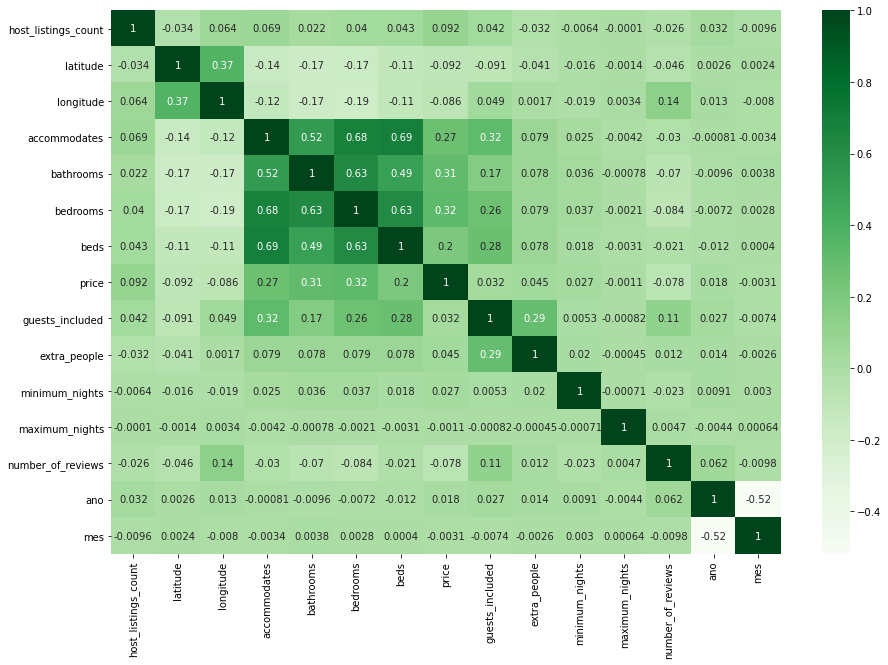

In [14]:
plt.figure(figsize=(15,10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')


In [15]:
#podemos ver que as colunas não tem uma forte correlação entre si para pensarmos em tirar.
#talvez as mais correlacionadas seriam o numero de quartos com numero de banheiros, ou accomodates x camas,
#mas isso já era esperado, não acredito que criará nenhum viés manter essas colunas para o modelo.

### Funções para análise e tirar outliers

Criei a função para excluir os Outliers, utilizando do conceito de Q1 -1.5x Amplitude para limite inferior e Q3 +1.5x Amplitude para limite superior desses dados.

Como temos uma base de quase 900 mil linhas, podemos retirar alguns valores que saem do padrão para treinar nosso modelo.
Exemplo de motivações para retirar outliers:
- Preços muito acima da distribuição de preços de diárias (podem indicar imoveis de luxo, ou preenchimento errado, em ambos os casos não serão úteis para o propósito do projeto

In [16]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 +1.5 * amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    return df, qtde_linhas - df.shape[0]

In [17]:
#criando graficos:
def diagrama_box(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna)

### Coluna Price

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


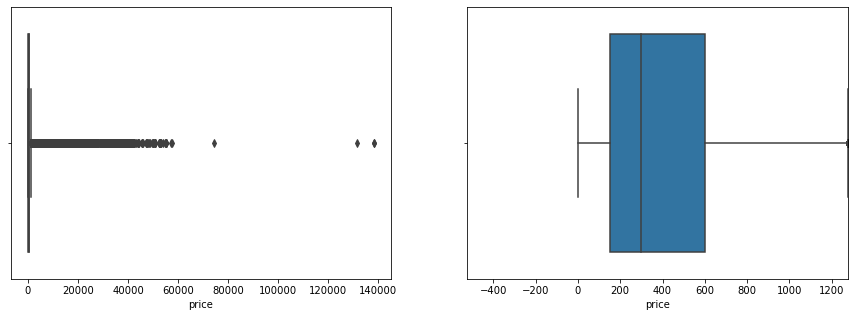

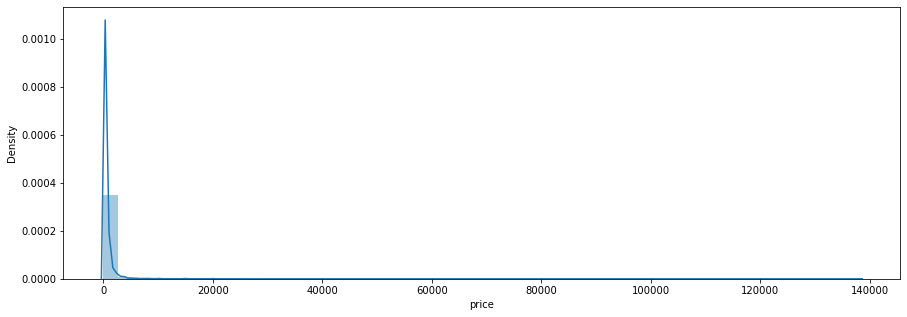

In [18]:
diagrama_box(base_airbnb['price'])
histograma(base_airbnb['price'])

In [19]:
#observando os graficos, penso que os valores acima do limite superior podem ter sido preenchidos errado, ou mesmo são 
#de imoveis de luxo, que possuem um perfil específico e não podem ser incluídos na análise de precificação.

base_airbnb, linhas_excluidas = excluir_outliers(base_airbnb, 'price')
print (linhas_excluidas)


87282


D:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


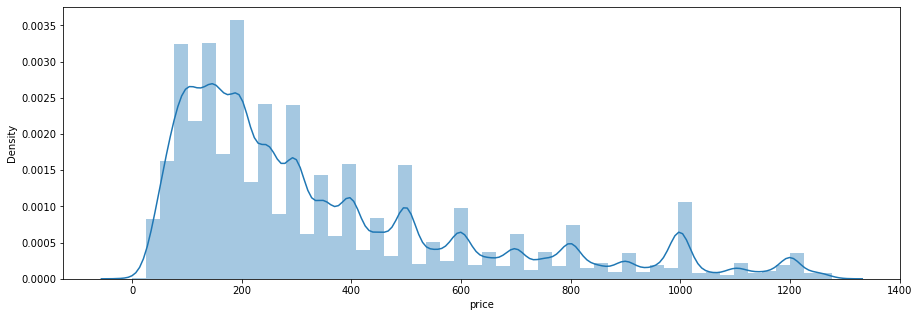

In [20]:
#Aqui vemos como ficou a distribuição dos dados após a remoção dos outliers
histograma(base_airbnb['price'])

### Extra_people

- Essa coluna trás dados de quanto é cobrado para trazer uma "pessoa a mais" do que o indicado no anuncio.
        -Exemplo: Uma casa possui 1 quarto e 1 cama de casal, é permitido 2 pessoas, porém caso queira levar uma terceira,
        terá que pagar uma taxa extra.

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


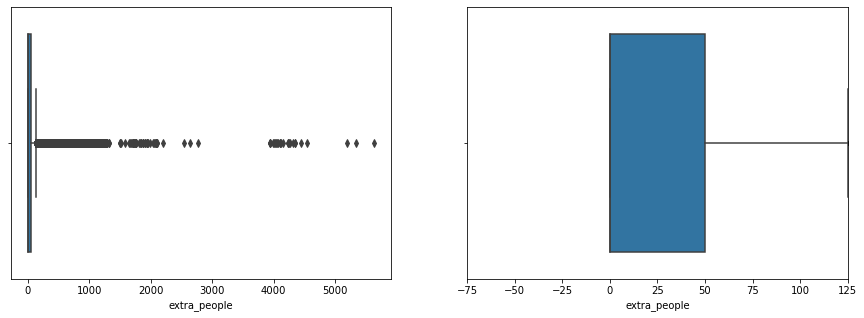

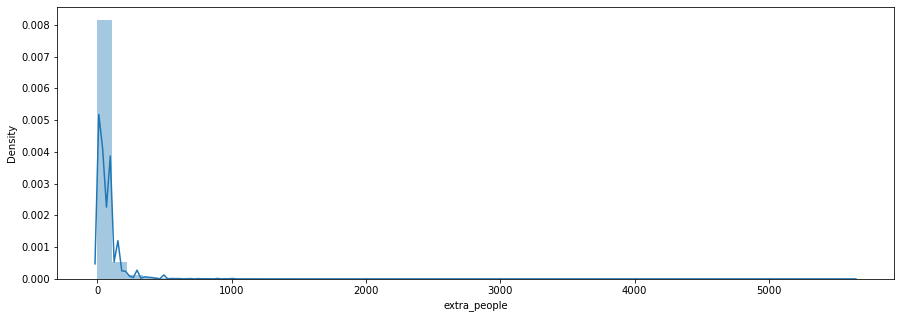

In [21]:
diagrama_box(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

59194


D:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


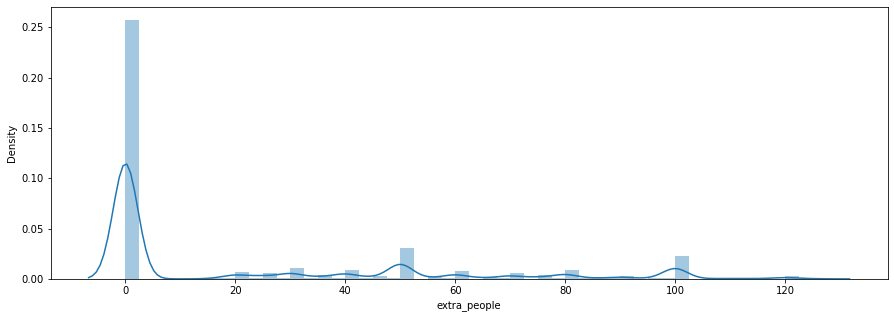

In [22]:
#novamente, vemos que em alguns lugares cobram mais de 5000 reais no valor extra. Não acredito ser um valor real,
#talvez seja apenas uma estratégia para colocar no sistema o fato de que não aceita pessoas extras, e não reflete
#no preço final da diária do imóvel
base_airbnb, linhas_excluidas = excluir_outliers(base_airbnb, 'extra_people')
print (linhas_excluidas)
histograma(base_airbnb['extra_people'])

### Host_listing_count
Da mesma forma, Iremos retirar os anuncios de usuários com mais de 6 imóveis no site, visto que eles podem ser
de imobiliárias e podem afetar no preço. o objetivo desse projeto é para que pessoas físicas comuns consigam listar seus imóveis a preço justo.

In [23]:
base_airbnb, linhas_excluidas = excluir_outliers(base_airbnb, 'host_listings_count')
print (linhas_excluidas)

97723


### Accommodates

In [24]:
base_airbnb, linhas_excluidas = excluir_outliers(base_airbnb, 'accommodates')
print (linhas_excluidas)

13146


### Bathrooms

In [25]:
base_airbnb, linhas_excluidas = excluir_outliers(base_airbnb, 'bathrooms')
print (linhas_excluidas)

6894


### Bedrooms

In [26]:
base_airbnb, linhas_excluidas = excluir_outliers(base_airbnb, 'bedrooms')

### Beds

In [27]:
base_airbnb, linhas_excluidas = excluir_outliers(base_airbnb, 'beds')
print (linhas_excluidas)

5622


### Guests_included
Nesta análise, percebi que essa coluna também pode ser excluída do projeto. Aparentemente é um problema de preenchimento, pois os dados se concentram demais em apenas "1 guest included", o que pode levar o modelo a considerar um dado que não influencia o preço em si.

<ipython-input-17-b3397c3f9bc2>:6: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))


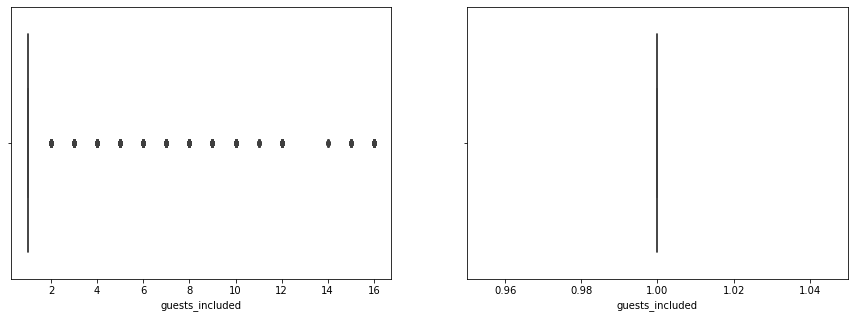

In [28]:
diagrama_box(base_airbnb['guests_included'])

In [29]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)

### Minimum_nights

In [30]:
base_airbnb, linhas_excluidas = excluir_outliers(base_airbnb, 'minimum_nights')
print (linhas_excluidas)

40383


### Maximum_nights
Aqui podemos ver outro problema de preenchimento, além de não parecer uma boa métrica para preço, na maioria dos casos o campo não precisa ser preenchido, então assume o valor "0" como padrão. Excluiremos a coluna.

In [31]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)

### Number_of_Reviews
Aqui com análise qualitativa, optei por tirar essa métrica do nosso modelo, pelos seguintes motivos:

1- um anunciante que entre na plataforma agora, não terá reviews, e isso pode dizer para o modelo que um anunciante novo sempre terá que anunciar na base de preços de quem anuncia pela primeira vez.

2- os anunciantes que possuem maior numero de reviews significam que estão a mais tempo na plataforma, e não que possuem os melhores imoveis/mais caros, ou seja, uma quantidade grande de reviews negativos somente diz que são vários reviews, o que não acredito fazer sentido para calculo do preço.

In [32]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)

### property_type
são campos de categoria, e vamos tratar para que sirvam para a análise

Para facilitar, todos os valores que tinham menos de 2000 ocorrências, agrupei em "outros" para que não fique muito nichado em categorias.

In [33]:
#property_type:
print(base_airbnb['property_type'].value_counts())

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


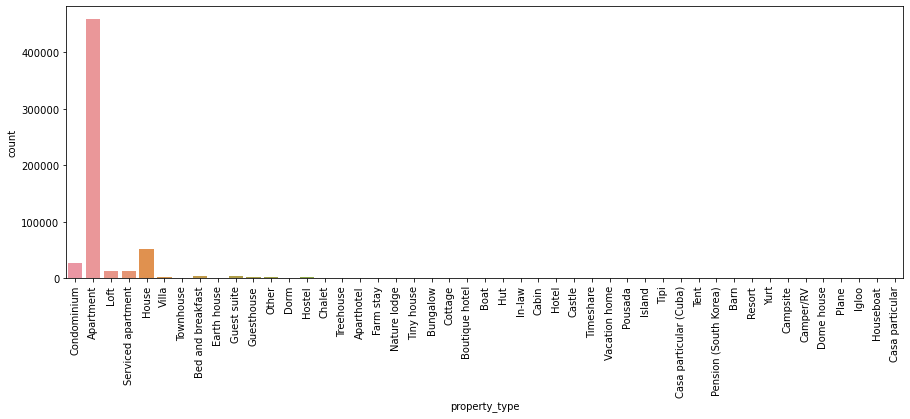

In [34]:
plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

In [35]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()

colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo]<2000:
        colunas_agrupar.append(tipo)
        

In [36]:
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type']==tipo , 'property_type'] = 'Outros'

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


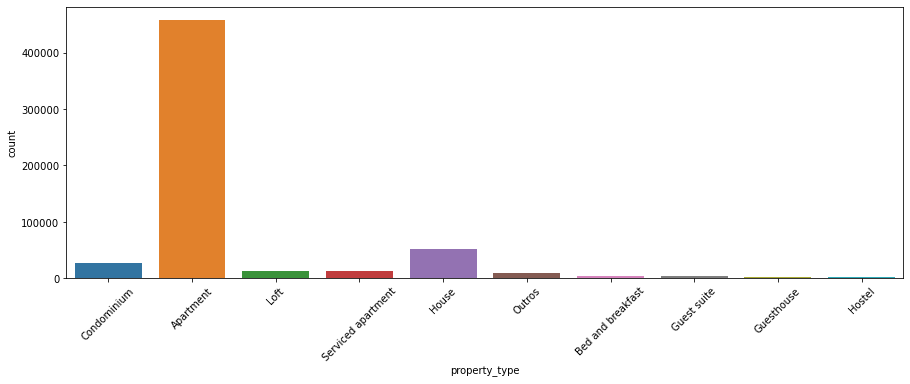

In [37]:
plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=45)

### room_type

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


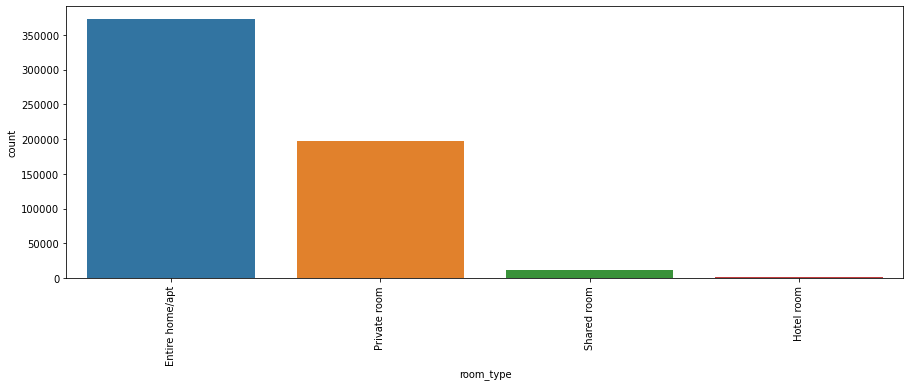

In [38]:
#numero de categorias está ok, não vamos alterar.
plt.figure(figsize=(15,5))
grafico = sns.countplot('room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### bed_type

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


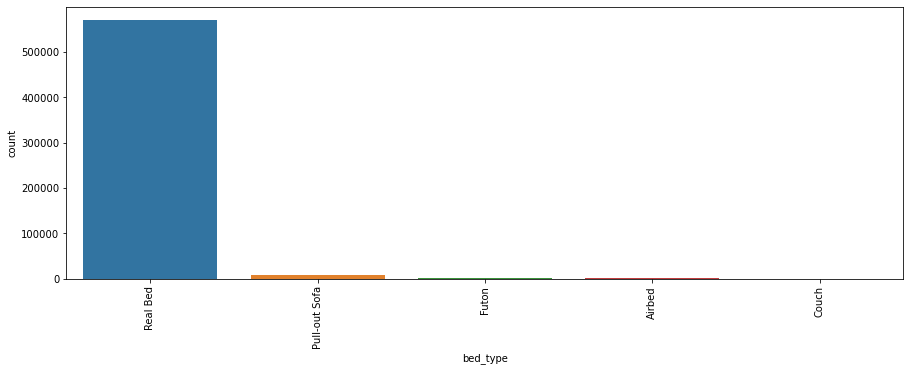

In [39]:
#numero de categorias ok, sem alterações
plt.figure(figsize=(15,5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### cancelation_policy

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


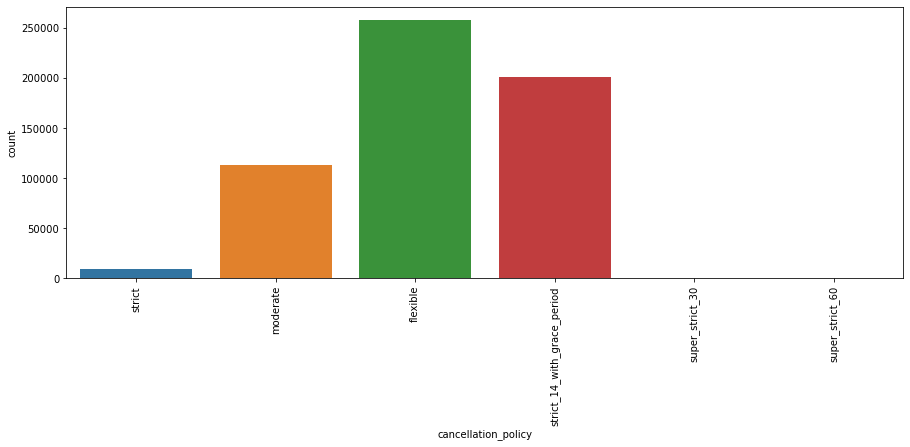

In [40]:
#numero de categorias ok, sem alterações
plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### Amenities
Como estamos lidando com um campo preenchido pelo usuário, e ele pode ou não refletir todos as comodidades que o imóvel possui, vou considerar a quantidade de itens descritos. Mesmo que isso cause o modelo a levar em conta itens como "cozinha" (que provavelmente a maioria possui mas nem todos preenchem por ser trivial), mostra um cuidado maior do usuário ao preencher, e até um esforço maior, o que pode significar maior valorização do imóvel

In [41]:
#criamos uma nova coluna com a quantidade de amenities
base_airbnb['comodidades'] = base_airbnb['amenities'].str.split(',').apply(len)
base_airbnb = base_airbnb.drop('amenities', axis = 1)


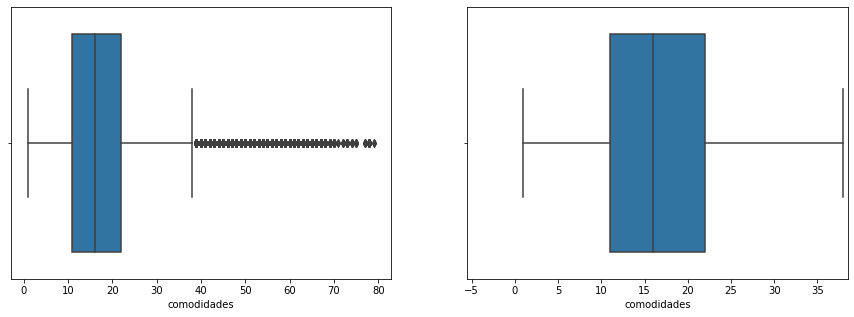

In [42]:
diagrama_box(base_airbnb['comodidades'])

In [43]:
base_airbnb, linhas_excluidas = excluir_outliers(base_airbnb, 'comodidades')
print (linhas_excluidas)

24343


### Colunas de Localização
colocamos aqui os preços em um mapa, e colocamos a cor ficando de azul para amarelo conforme se concentram os maiores preços. Aqui podemos ver que a localização realmente influencia no preço final, como é de conhecimento público as áreas da zona sul do Rio serem mais caras, a nossa latitude e longitude serão bem importantes para a análise.

Para facilitar o processamento, incluí uma amostra aleatória de 50000 dados, que já acredito refletir bem o conjunto total de dados.

In [44]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra['latitude'].mean(), 'lon':amostra['longitude'].mean()}

mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5, center = centro_mapa, zoom=10,
                        mapbox_style = 'stamen-terrain')
mapa.show()

### Encoding

Vamos ajustar os valores de texto(categorias e True/False) para numeros para que o nosso modelo consiga ler esses arquivos

Para isso, utilizaremos 1 e 0 para True e False, respectivamente, e utilizaremos variáveis dummies para o encoding das categorias, para que o modelo possa reconhecer como 1 se a categoria é a daquele imóvel e 0 para todas as outras.

In [45]:
colunas_tf = ['host_is_superhost' ,'instant_bookable' ,'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t' ,coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f' ,coluna] = 0

In [46]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(base_airbnb_cod, columns=colunas_categorias)
base_airbnb_cod.head()

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  bed_type_Couch  \
1        1.0       2.0   2.0  270.0          51.0  ...               0   
3        1.0       1.0   2.0  161.0          45.0  ...               0   
4        1.0       1.0   2.0  222.0          68.0  ...               0   
5        1.5       1.0   2.0  308.0          86.0  ...               0   
6        1.0       1.0   2.0  219.0          80.0  ...               0   

  bed_type_Futon bed_type_Pull-out Sofa  bed_type_Real Bed  \
1              0                      0                  1   
3              0                      0                  1   
4              0                      0                  1   
5              0                      0                  1   
6              0                      0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   
6                             0                             0   

   cancellation_policy_strict  \
1                           1   
3                           1   
4                           1   
5                           1   
6                           1   

   cancellation_policy_strict_14_with_grace_period  \
1                                                0   
3                                                0   
4                                                0   
5                                                0   
6                                                0   

   cancellation_policy_super_strict_30  cancellation_policy_super_strict_60  
1                                    0                                    0  
3                                    0                                    0  
4                                    0                                    0  
5                                    0                                    0  
6                                    0                                    0  

[5 rows x 41 columns]

### Modelo de Previsão

Modelos usados:

-Linear Regression
Método simples, porém rápido caso tenha bons valores de R² e RSME.

-Random Forest
Método um pouco mais completo, e que explora aleatoriamente as árvores de decisão, escolhendo sempre a melhor pergunta para cada dualidade.

-Extra Trees
Como o Random Forest, porém ao invés de buscar a melhor pergunta sempre, usa perguntas também aleatórias, o que pode nos trazer outro resultado, talvez até mais satisfatório.

Quanto à disposição, serão 80% dos dados para treino e 20% para teste.

Para avaliar os modelos, definimos R² como a principal métrica, e RSME (raíz do erro quadrático médio) como auxiliar

In [47]:
def avaliar_modelo(nome_modelo, y_test, previsao):
    r2 = r2_score(y_test, previsao)
    RSME = np.sqrt(mean_squared_error(y_test, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2}\nRSME: {RSME}'

In [48]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,}

y=base_airbnb_cod['price']
x=base_airbnb_cod.drop('price', axis=1)

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.8)

for nome_modelo, modelo in modelos.items():
    tempo_inicial= time.time()
    modelo.fit(x_train, y_train)
    previsao = modelo.predict(x_test)
    tempo_final= time.time()
    tempo_total=tempo_final - tempo_inicial
    print("\n", avaliar_modelo(nome_modelo, y_test, previsao))
    print("Modelo executado em {:.2f} segundos".format(tempo_total))


 Modelo RandomForest:
R²:0.9746626481740804
RSME: 42.33619684573979
Modelo executado em 330.29 segundos

 Modelo LinearRegression:
R²:0.3307787240336165
RSME: 217.57856126434848
Modelo executado em 1.50 segundos

 Modelo ExtraTrees:
R²:0.9760578725967662
RSME: 41.15405177100137
Modelo executado em 309.07 segundos


### Análise do Melhor Modelo

Escolhemos o modelo de ExtraTrees para avaliação. Foi o que apresentou tanto o melhor R² quanto o menor Erro quadrático médio. Por mais que sejam parecidos, há uma melhora de 0.002 pontos em R² quando comparamos os 2 modelos. Além disso, o ExtraTrees teve uma vantagem de 22 segundos no tempo de processamento. O Linear Regression com certeza foi o mais rápido, porém a acurácia dele está muito fora do aceitável.

D:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names



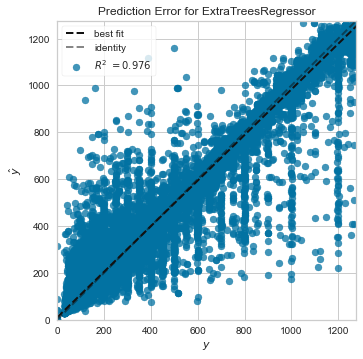

In [54]:
x, y = load_concrete()
melhor_modelo = modelo_et
visualizer = prediction_error(melhor_modelo, x_train, y_train, x_test, y_test)

### Ajustes e Melhorias no Melhor Modelo

Agora analisando quais features estão sendo mais decisivas no processo de cálculo do preço, para ver se conseguimos diminuir a quantidade de dados processados e melhorar sua performance

In [50]:
features_df = pd.DataFrame(modelo_et.feature_importances_,x_train.columns)
features_df = features_df.sort_values(by=0, ascending=False)
display (features_df)

0
bedrooms                                         0.116454
latitude                                         0.103718
longitude                                        0.101282
comodidades                                      0.089069
extra_people                                     0.086934
accommodates                                     0.074188
bathrooms                                        0.068187
minimum_nights                                   0.065672
room_type_Entire home/apt                        0.062186
beds                                             0.052699
host_listings_count                              0.039861
instant_bookable                                 0.021650
cancellation_policy_flexible                     0.019673
host_is_superhost                                0.013443
cancellation_policy_moderate                     0.012636
property_type_Apartment                          0.012558
ano                                              0.011216
cancellation_policy_strict_14_with_grace_period  0.007551
property_type_House                              0.007119
property_type_Condominium                        0.005296
mes                                              0.004624
room_type_Private room                           0.004533
bed_type_Pull-out Sofa                           0.002428
property_type_Serviced apartment                 0.002291
property_type_Outros                             0.002267
bed_type_Real Bed                                0.002146
property_type_Loft                               0.002137
room_type_Shared room                            0.001852
property_type_Bed and breakfast                  0.001363
property_type_Guesthouse                         0.000914
cancellation_policy_strict                       0.000767
bed_type_Futon                                   0.000730
property_type_Guest suite                        0.000681
property_type_Hostel                             0.000639
bed_type_Airbed                                  0.000379
bed_type_Couch                                   0.000340
room_type_Hotel room                             0.000308
cancellation_policy_super_strict_60              0.000170
cancellation_policy_super_strict_30              0.000039
is_business_travel_ready                         0.000000

- Percebemos que a coluna "is_business_travel_ready" não tem nenhum impacto no preço calculado pelo modelo, então irei retirar a coluna, treinar novamente o ExtraTrees e ver como se comporta

In [60]:
base_airbnb.cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [62]:
y=base_airbnb_cod['price']
x=base_airbnb_cod.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.8)

inicio = time.time()
modelo_et.fit(x_train, y_train)
previsao = modelo_et.predict(x_test)
final = time.time()

print(avaliar_modelo(modelo_et, y_test, previsao))
print("\n{} segundos".format(final-inicio))

Modelo ExtraTreesRegressor():
R²:0.9759940365452695
RSME: 41.20887904909544

310.15739917755127 segundos


- Não irei remover outras colunas, pois mesmo que seja quase irrelevante a "cancellation_policy_super_strict_30", ela faz parte das variáveis dummies de cancelation policy, que possuem dados pouco mais relevantes em outras categorias. o que concluímos é que quando a pessoa preenche que a politica de cancelamento é flexível (cancellation_policy_flexible	0.019088) ela pode impactar no preço, porém quando é super restrita, não.

### DEPLOY
-exportei a nossa base tratada para um arquivo csv (já com colunas retiradas, com dummies, etc) e também usei o joblib para criar um arquivo para o nosso modelo treinado. Com isso, ficará muito mais rápido ler o arquivo com o streamlit do que treiná-lo toda vez que for utilizar.

In [69]:
#x['price'] = y
#x.to_csv('dados.csv', sep=';')

In [70]:
#import joblib

In [72]:
#joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']